In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import math
import numpy as np
import scipy
import os
import nept

In [2]:
thisdir = os.getcwd()
# data_filepath = os.path.join(thisdir, "cache", "data")
output_filepath = os.path.join(thisdir, "plots", "experience")
if not os.path.exists(output_filepath):
    os.makedirs(output_filepath)

In [3]:
import info.r192_exp03 as info

In [4]:
# rat = "R187"
# # data_filepath = os.path.join("/home", "emily", "data", rat+"_"+info.date+"_recording")
# # data_filepath = os.path.join("/home", "emily", "data", "RR1_"+info.date+"_test")

# data_filepath = os.path.join("E:\\", "data", "data-experience", rat, "RR3", rat+"_"+info.date+"_recording")
# # data_filepath = os.path.join("E:\\", "data", "data-experience", rat, "RR1_"+info.date+"_test")

# data_filepath = os.path.join("/home/emily/data/R192_"+date+"_recording")

# import info.r187_tmaze as info

In [5]:
data_filepath = os.path.join("E:\\", "data", "data-experience", info.rat_id, "RR1", info.rat_id+"_"+info.date+"_recording")

In [6]:
txt_filepath = os.path.join(data_filepath, info.date+"_experience.txt")
txt_filepath

'E:\\data\\data-experience\\R192\\RR1\\R192_2019-09-11_recording\\2019-09-11_experience.txt'

In [7]:
with open(txt_filepath) as f:
    mylist = f.read().splitlines() 
f.close()

In [8]:
probe_trials = [trial for trial in mylist if trial.startswith("~")]
probe_trials

['~ South -',
 '~ West -',
 '~ South +',
 '~ West -',
 '~ North -',
 '~ West -',
 '~ South +',
 '~ West +']

In [9]:
probe_choice = [choice[2] for choice in probe_trials]
probe_choice

['S', 'W', 'S', 'W', 'N', 'W', 'S', 'W']

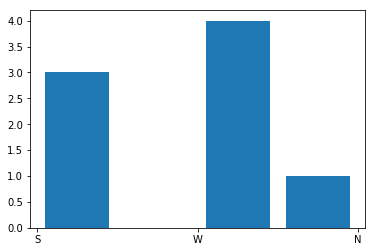

In [10]:
n_bins = 4
plt.hist(probe_choice, n_bins, rwidth=0.8)
plt.show()

In [11]:
def get_tmaze_trials(events):
    if events["trial_start"][0] > events["trial_end"][0]:
        starts = events["trial_end"]
        stops = events["trial_start"]
    else:
        starts = events["trial_start"]
        stops = events["trial_end"] 
    print(starts[-5:], stops[-5:])
    print(len(starts), len(stops))
    if len(starts) > len(stops):
        starts = starts[:-1]
    if len(starts) < len(stops):
        stops = stops[:-1]
    print(len(starts), len(stops))
    if stops[0]-starts[0] > 0:
        trials = nept.Epoch(starts, stops)
    else:
        trials = nept.Epoch(stops, starts)

    return trials

In [12]:
def get_exp_trials(events):
    starts = np.sort(np.append(events["trial_start"], [info.task_times["run1"].start, info.task_times["run2"].start]))
    stops = events["trial_end"]

    return nept.Epoch(starts, stops)

In [13]:
event_filename = info.date+"_Events.nev"
events = nept.load_events(os.path.join(data_filepath, event_filename), info.event_labels)
# trials = get_exp_trials(events)
# print("Mean:", np.mean(trials.durations), "(s) +/- sem:", scipy.stats.sem(trials.durations))

In [14]:
pbs_labels = ["north_pb", "east_pb", "south_pb", "west_pb"]

In [15]:
lfp = nept.load_lfp(os.path.join(data_filepath, info.lfp_swr_filename))

In [16]:
os.path.join(data_filepath, info.lfp_swr_filename)

'E:\\data\\data-experience\\R192\\RR1\\R192_2019-09-11_recording\\2019-09-11_CSC4b.ncs'

In [17]:
lfp_diff = np.diff(lfp.time)
breaks = np.where(lfp_diff > 20)[0]
print(len(breaks))

4


In [18]:
recording_breaks = [lfp.time[0]]
for pause in breaks:
    recording_breaks.append(lfp.time[pause])
    recording_breaks.append(lfp.time[pause+1])
recording_breaks.append(np.max(lfp.time))

In [19]:
starts = recording_breaks[::2]
stops = recording_breaks[1::2]
print(starts, stops)

[809.787867, 1758.032867, 3251.007867, 4212.613867, 5554.2988669999995] [1711.5678669999998, 3184.868867, 4152.413866999999, 5522.695866999999, 6456.294867]


In [20]:
events["recording_start"]

array([ 809.787382, 1758.032382, 3251.007382, 4212.613382, 5554.298382])

In [21]:
events["recording_stop"]

array([1711.568351, 3184.869351, 4152.414351, 5522.696351, 6456.295351])

In [22]:
for start, stop in zip(starts, stops):
    print(str([math.ceil(start * 100.0) / 100.0]) + ", " + str([math.floor(stop * 100.0) / 100.0]))

[809.79], [1711.56]
[1758.04], [3184.86]
[3251.01], [4152.41]
[4212.62], [5522.69]
[5554.3], [6456.29]


In [23]:
1/0

ZeroDivisionError: division by zero

In [ ]:
breaks_start = nept.find_nearest_indices(lfp.time, starts)
breaks_stop = nept.find_nearest_indices(lfp.time, stops)

plt.plot(lfp.time, lfp.data)
for i in breaks_start:
    plt.plot(lfp.time[i], lfp.data[i], "r.", ms=20)
for j in breaks_stop:
    plt.plot(lfp.time[j], lfp.data[j], "g.", ms=20)
plt.show()

In [ ]:
position_filename = info.date+"_VT1.nvt"
position = nept.load_position(os.path.join(data_filepath, position_filename), pxl_to_cm=[info.pxl_to_cm["x"], info.pxl_to_cm["y"]])

In [ ]:
phase = 'run1'
sliced_position = position.time_slice(info.task_times[phase].start, info.task_times[phase].stop)

plt.plot(sliced_position.x, sliced_position.y, ".")
plt.show()

In [ ]:
plt.plot(sliced_position.x, sliced_position.time, ".")
plt.show()

In [ ]:
plt.plot(sliced_position.x[:50000], sliced_position.y[:50000], ".")
plt.show()

In [ ]:
plt.plot(position.x, position.y, ".")
plt.show()

In [ ]:
sliced_lfp = lfp.time_slice(info.task_times["rest2"].start, info.task_times["rest2"].stop)

In [ ]:
# Find SWRs for the whole session
z_thresh = 2.0
power_thresh = 3.0
merge_thresh = 0.02
min_length = 0.05
swrs = nept.detect_swr_hilbert(sliced_lfp, 
                               fs=info.fs, 
                               thresh=(140.0, 250.0), 
                               z_thresh=z_thresh,
                               merge_thresh=merge_thresh, 
                               min_length=min_length)
# swrs = nept.find_multi_in_epochs(spikes, swrs, min_involved=4)

# rest_epochs = nept.rest_threshold(position, thresh=12., t_smooth=0.8)

In [ ]:
for i in range(10):
    ok = sliced_lfp.time_slice(swrs.starts[i], swrs.stops[i])

    buffer = 0.1
    plt.plot(sliced_lfp.time, sliced_lfp.data)
    plt.plot(ok.time, ok.data)
    plt.xlim(ok.time[0]-buffer, ok.time[-1]+buffer)
    plt.show()

In [ ]:
spikes = nept.load_spikes(data_filepath)

In [ ]:
n_rows = len(spikes)
add_rows = int(n_rows / 8)

ms = 300 / n_rows
mew = 0.5
spike_loc = 1

fig = plt.figure(figsize=(8, 8))

ax = plt.subplot()
for idx, neuron_spikes in enumerate(spikes):
    ax.plot(neuron_spikes.time, np.ones(len(neuron_spikes.time)) + (idx * spike_loc), '|', color='k', ms=ms, mew=mew)

ax.axis('off')
plt.show()

In [ ]:
def get_only_tuning_curves(info, position, spikes, epoch_of_interest):
    sliced_position = position.time_slice(epoch_of_interest.starts, epoch_of_interest.stops)
    sliced_spikes = [spiketrain.time_slice(epoch_of_interest.starts, epoch_of_interest.stops) for spiketrain in spikes]

    # Limit position and spikes to only running times
    run_epoch = nept.run_threshold(sliced_position, thresh=10., t_smooth=0.8)
    run_position = sliced_position[run_epoch]
    tuning_spikes = [spiketrain.time_slice(run_epoch.starts, run_epoch.stops) for spiketrain in sliced_spikes]

    tuning_curves = nept.tuning_curve_2d(run_position, tuning_spikes, info.xedges, info.yedges,
                                         occupied_thresh=0.5, gaussian_std=0.3)

    return tuning_curves

In [ ]:
np.where(np.diff(lfp.time) > 1)

In [ ]:
tmaze_times = nept.Epoch(lfp.time[635231], lfp.time[5692603])

In [ ]:
tuning_curves = get_only_tuning_curves(info, position, spikes, tmaze_times)

In [ ]:
xx, yy = np.meshgrid(info.xedges, info.yedges)

cmap = plt.cm.get_cmap('bone_r', 25)

for tuning_curve in tuning_curves:
    plt.figure(figsize=(6, 5))
    plt.plot(position.x, position.y, ".", alpha=0.1, ms=0.3, color="y")
    pp = plt.pcolormesh(xx, yy, tuning_curve, vmin=0.01, cmap=cmap)
    plt.colorbar(pp)
    plt.axis('off')
    plt.tight_layout()
    plt.show()